In [1]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import os 
import healpy as hp
import matplotlib.colors as mcolors

def rpm_to_period(rpm):
    return 60.0 / rpm
import h5py

def read_h5_file(h5_path):
    # "./name/n.h5"のパスを作成
    with h5py.File(h5_path, 'r') as f:
        attack_angle_group = f['attack_angle']
        planets_group_std = attack_angle_group['planets']['std']
        planets_group_uniformity = attack_angle_group['planets']['uniformity']
        ss_group = f['ss']
        
        PCCS_group = attack_angle_group['PCCS']
        attack_angles_PCCS_SD = PCCS_group['std'][()]
        attack_angles_PCCS_uniformity = PCCS_group['uniformity'][()]
        integration_times_PCCS = f['integration_time']['PCCS'][()]
        
        attack_angles_planets_SD = {}
        attack_angles_planets_uniformity = {}
        integration_times_planets = {}
        
        for planet in planets_group_std:
            planet_SD = planets_group_std[planet][()]
            planet_uniformity = planets_group_uniformity[planet][()]
            integration_time = f[f'integration_time/planets/{planet}'][()]
            attack_angles_planets_SD[planet] = planet_SD
            attack_angles_planets_uniformity[planet] = planet_uniformity
            integration_times_planets[planet] = integration_time
        
        ss = {f: ss_group[f][()] for f in ss_group}
        
        result = {
            'attack_angles': {
                'PCCS': {
                    'SD': attack_angles_PCCS_SD,
                    'uniformity': attack_angles_PCCS_uniformity
                },
                'Planets': {
                    'SD': attack_angles_planets_SD,
                    'uniformity': attack_angles_planets_uniformity
                }
            },
            'integration_times': {
                'PCCS': integration_times_PCCS,
                'Planets': integration_times_planets
            },
            'ss': ss
        }
        return result


def get_data(dir_path):
    step = 3
    alpha = np.arange(step, 95-step, step)
    T_alpha = np.logspace(3.2, 7.2, 50)
    T_spin = np.zeros([len(alpha), len(T_alpha)])
    T_prec = np.zeros([len(alpha), len(T_alpha)])
    Alpha = np.zeros([len(alpha), len(T_alpha)])
    Beta = np.zeros([len(alpha), len(T_alpha)])
    
    planets_integration_time = np.zeros([len(alpha), len(T_alpha), 5])
    pccs_integration_time = np.zeros([len(alpha), len(T_alpha), 45])
    
    planets_sd = np.zeros([len(alpha), len(T_alpha), 5])
    planets_unifo = np.zeros([len(alpha), len(T_alpha), 5])
    
    pccs_psi_sd = np.zeros([len(alpha), len(T_alpha), 45])
    pccs_psi_unifo = np.zeros([len(alpha), len(T_alpha), 45])
    planet_list = ["mars", "jupiter", "saturn", "uranus", "neptune"]
    n = 1
    for i in range(0, len(alpha)):
        for j in range(0, len(T_alpha)):
            file_path = dir_path + "/output_{}.h5".format(n)
            if os.path.exists(file_path) == True:
                data = read_h5_file(file_path)
                n += 1
                Alpha[i,j] = data["ss"]["alpha"]
                Beta[i,j] = data["ss"]["beta"]
                T_spin[i,j] = rpm_to_period(data["ss"]["spin_rpm"])
                T_prec[i,j] = rpm_to_period(data["ss"]["prec_rpm"])
                for k in range(0, len(planet_list)):
                    planets_integration_time[i,j,k] = data["integration_times"]["Planets"][planet_list[k]]
                    planets_sd[i,j,k] = data["attack_angles"]["Planets"]["SD"][planet_list[k]]
                    planets_unifo[i,j,k] = data["attack_angles"]["Planets"]["uniformity"][planet_list[k]]
                for k in range(0, 45):
                    pccs_integration_time[i,j,k] = data["integration_times"]["PCCS"][k]
                    pccs_psi_sd[i,j,k] = data["attack_angles"]["PCCS"]["SD"][k]
                    pccs_psi_unifo[i,j,k] = data["attack_angles"]["PCCS"]["uniformity"][k]
    return {"planets_inttime":planets_integration_time, 
            "pccs_inttime"   :pccs_integration_time,
            "planets_psi_sd"     :planets_sd,
            "planets_psi_unifo"  :planets_unifo,
            "pccs_psi_sd"    :pccs_psi_sd,
            "pccs_psi_unifo" :pccs_psi_unifo,
            "T_spin"         :T_spin, 
            "T_prec"         :T_prec, 
            "Alpha"          :Alpha, 
            "Beta"           :Beta,
           }

In [2]:
df = pd.read_csv("/home/cmb/yusuket/scan/functions/PCCS_broadband_pol_source_list.csv")
path = "/home/cmb/yusuket/gp/scan_optimisation/calibration/comp_source_obs/output/230321"
data = get_data(path)

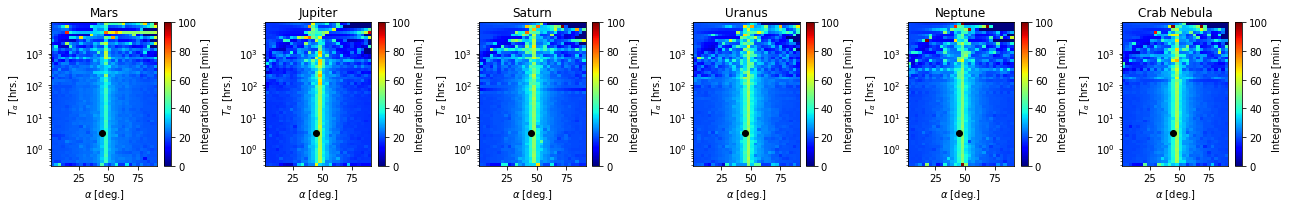

In [7]:
fig, axes = plt.subplots(1, 6, figsize=(18, 3))
comp_source_list = ["Mars", "Jupiter", "Saturn", "Uranus", "Neptune", "Crab Nebula"]

for i in range(6):
    if i != 5:
        ax = axes[i]
        P = ax.pcolormesh(data["Alpha"], data["T_prec"]/60/60, data["planets_inttime"][:,:,i]/60, cmap="jet", vmin=0, vmax=100)
        ax.scatter(45, 192.348/60, color="black")
        ax.set_xlabel(r"$\alpha$ [deg.]")
        ax.set_ylabel(r"$T_{\alpha}$ [hrs.]")
        ax.set_title("{}".format(comp_source_list[i]))
        ax.set_yscale("log")
        fig.colorbar(P, ax=ax, label=r"Integration time [min.]")
    else:
        ax = axes[i]
        P = ax.pcolormesh(data["Alpha"], data["T_prec"]/60/60, data["pccs_inttime"][:,:,23]/60, cmap="jet", vmin=0, vmax=100)
        ax.scatter(45, 192.348/60, color="black")
        ax.set_xlabel(r"$\alpha$ [deg.]")
        ax.set_ylabel(r"$T_{\alpha}$ [hrs.]")
        ax.set_title("{}".format(comp_source_list[i]))
        ax.set_yscale("log")
        fig.colorbar(P, ax=ax, label=r"Integration time [min.]")
    
plt.tight_layout()
plt.savefig("./comp_source_integration_time.pdf")

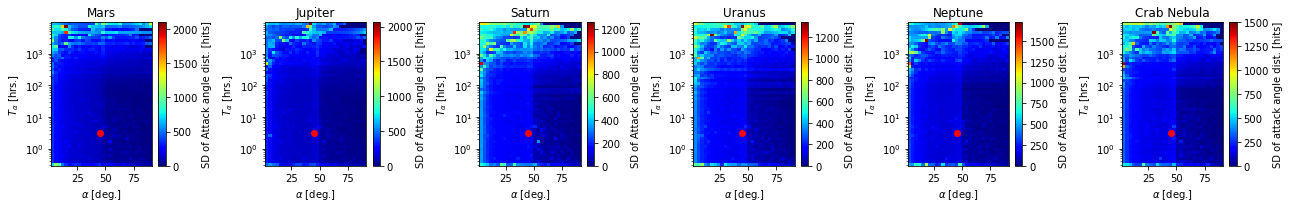

In [4]:
fig, axes = plt.subplots(1, 6, figsize=(18, 3))
comp_source_list = ["Mars", "Jupiter", "Saturn", "Uranus", "Neptune", "Crab Nebula"]

for i in range(6):
    if i != 5:
        ax = axes[i]
        P = ax.pcolormesh(data["Alpha"], data["T_prec"]/60/60, data["planets_psi_sd"][:,:,i], cmap="jet")
        ax.scatter(45, 192.348/60, color="r")
        ax.set_xlabel(r"$\alpha$ [deg.]")
        ax.set_ylabel(r"$T_{\alpha}$ [hrs.]")
        ax.set_title("{}".format(comp_source_list[i]))
        ax.set_yscale("log")
        fig.colorbar(P, ax=ax, label=r"SD of Attack angle dist. [hits]")
    else:
        ax = axes[i]
        P = ax.pcolormesh(data["Alpha"], data["T_prec"]/60/60, data["pccs_psi_sd"][:,:,23], cmap="jet", vmin=0, vmax=1500)
        ax.scatter(45, 192.348/60, color="r")
        ax.set_xlabel(r"$\alpha$ [deg.]")
        ax.set_ylabel(r"$T_{\alpha}$ [hrs.]")
        ax.set_title("{}".format(comp_source_list[i]))
        ax.set_yscale("log")
        fig.colorbar(P, ax=ax, label=r"SD of attack angle dist. [hits]")
    
plt.tight_layout()

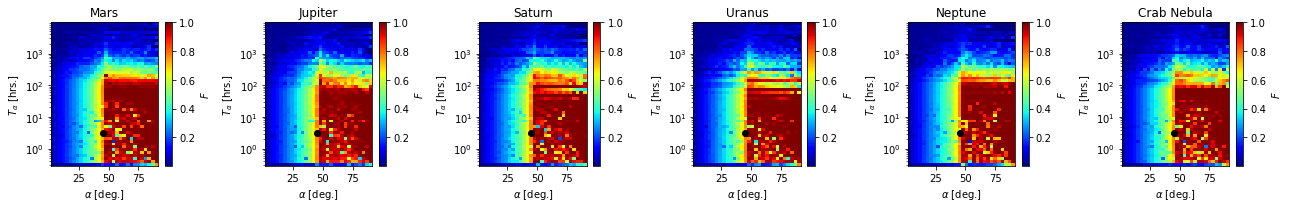

In [31]:
fig, axes = plt.subplots(1, 6, figsize=(18, 3))
comp_source_list = ["Mars", "Jupiter", "Saturn", "Uranus", "Neptune", "Crab Nebula"]

for i in range(6):
    if i != 5:
        ax = axes[i]
        P = ax.pcolormesh(data["Alpha"], data["T_prec"]/60/60, data["planets_psi_unifo"][:,:,i], cmap="jet")
        ax.scatter(45, 192.348/60, color="black")
        ax.set_xlabel(r"$\alpha$ [deg.]")
        ax.set_ylabel(r"$T_{\alpha}$ [hrs.]")
        ax.set_title("{}".format(comp_source_list[i]))
        ax.set_yscale("log")
        fig.colorbar(P, ax=ax, label=r"$F$")
    else:
        ax = axes[i]
        P = ax.pcolormesh(data["Alpha"], data["T_prec"]/60/60, data["pccs_psi_unifo"][:,:,23], cmap="jet")
        ax.scatter(45, 192.348/60, color="black")
        ax.set_xlabel(r"$\alpha$ [deg.]")
        ax.set_ylabel(r"$T_{\alpha}$ [hrs.]")
        ax.set_title("{}".format(comp_source_list[i]))
        ax.set_yscale("log")
        fig.colorbar(P, ax=ax, label=r"$F$")
plt.tight_layout()
plt.savefig("./comp_source_ang_coverage.pdf")

In [28]:
data["T_prec"][0,11]/60

194.2099344755513

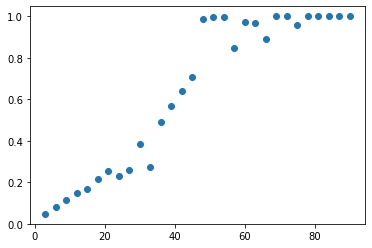

In [30]:
plt.plot(data["Alpha"][:,0], data["planets_psi_unifo"][:,11,1], "o")

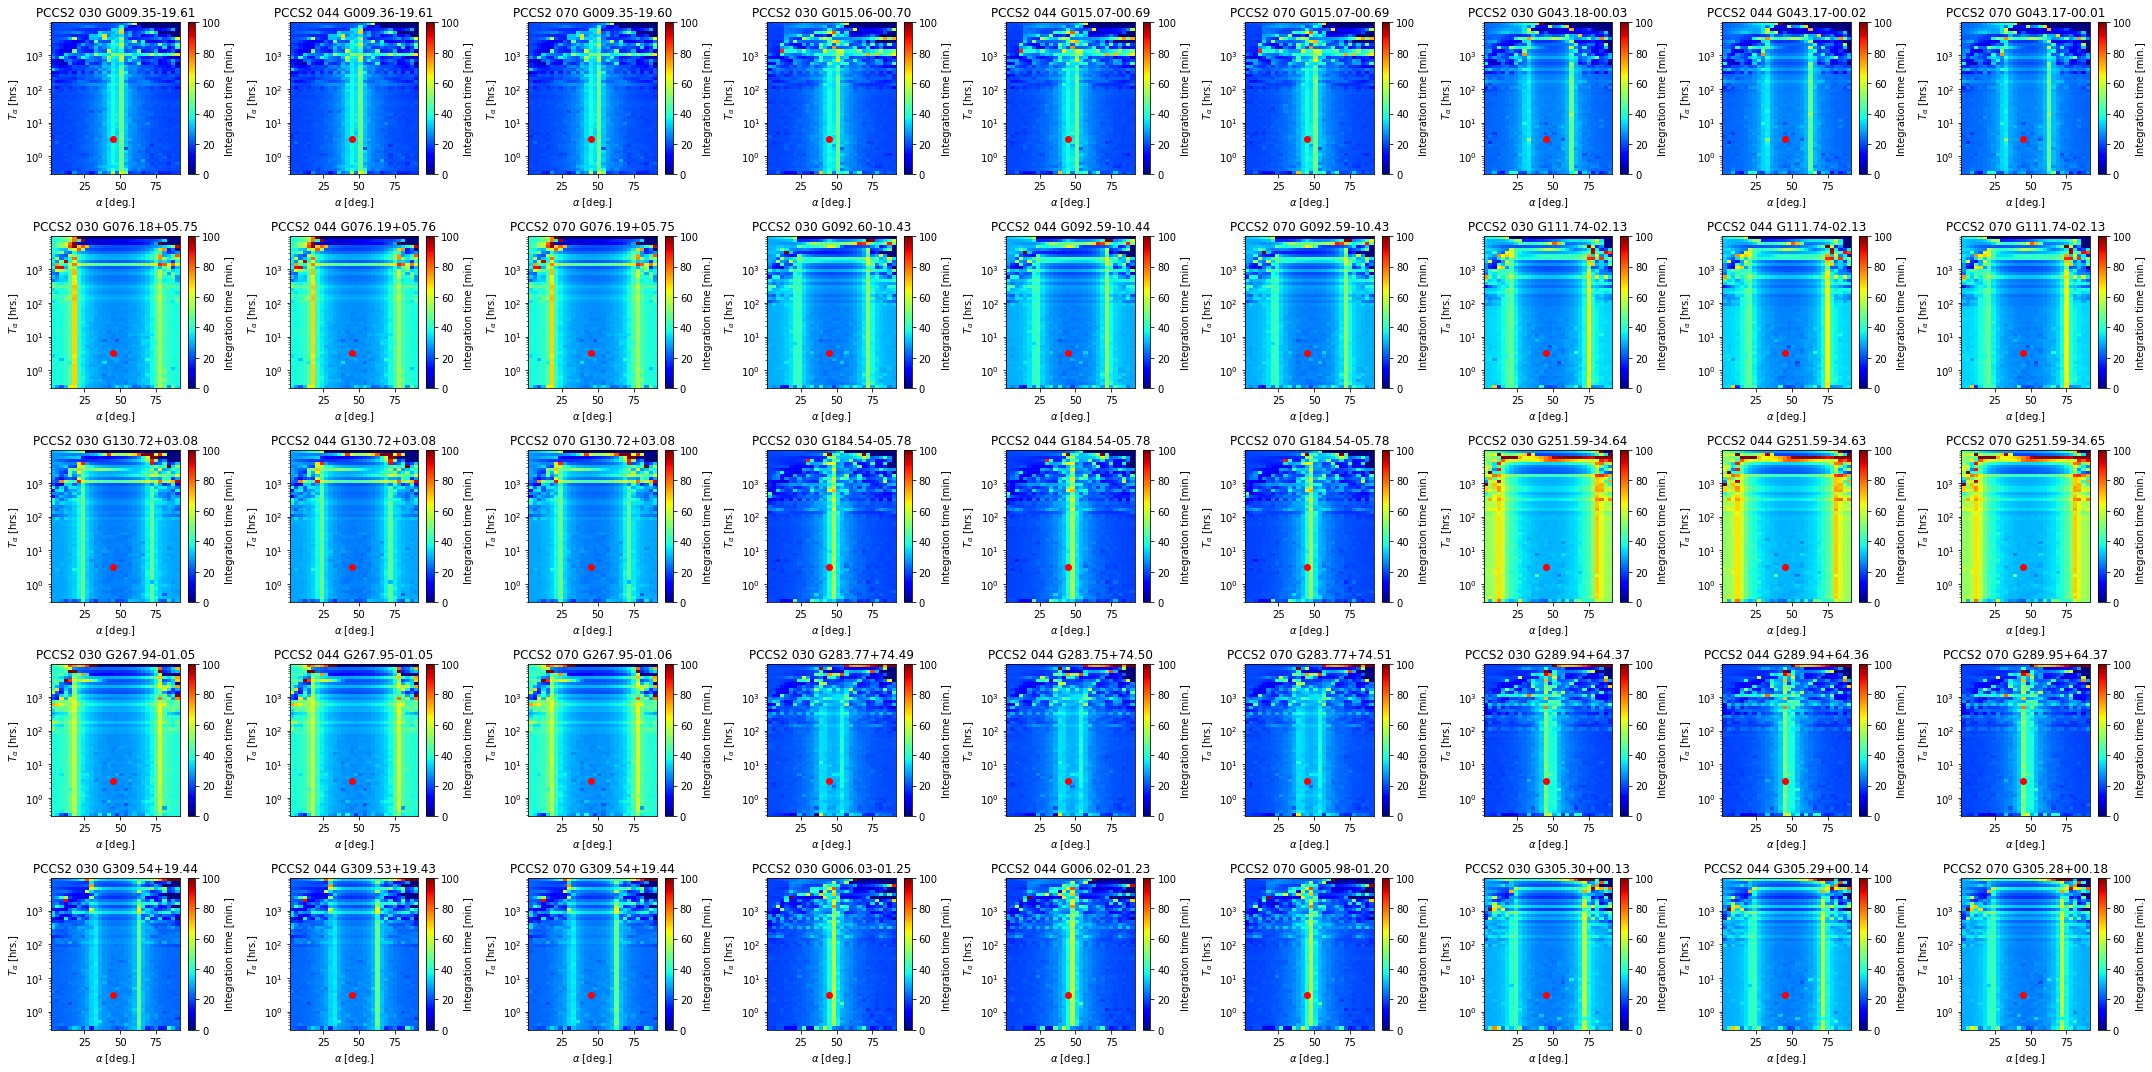

In [13]:
figsize = (30, 15)
fig, axes = plt.subplots(5, 9, figsize=figsize)
k = 0
for i in range(5):
    for j in range(9):
        ax = axes[i, j]
        P = ax.pcolormesh(data["Alpha"], data["T_prec"]/60/60, data["pccs_inttime"][:,:,k]/60, cmap="jet", vmin=0, vmax=100)
        ax.scatter(45, 192.348/60, color="r")
        ax.set_xlabel(r"$\alpha$ [deg.]")
        ax.set_ylabel(r"$T_{\alpha}$ [hrs.]")
        ax.set_title("{}".format(df["NAME"][k]))
        ax.set_yscale("log")
        fig.colorbar(P, ax=ax, label=r"Integration time [min.]")
        k += 1
plt.tight_layout()

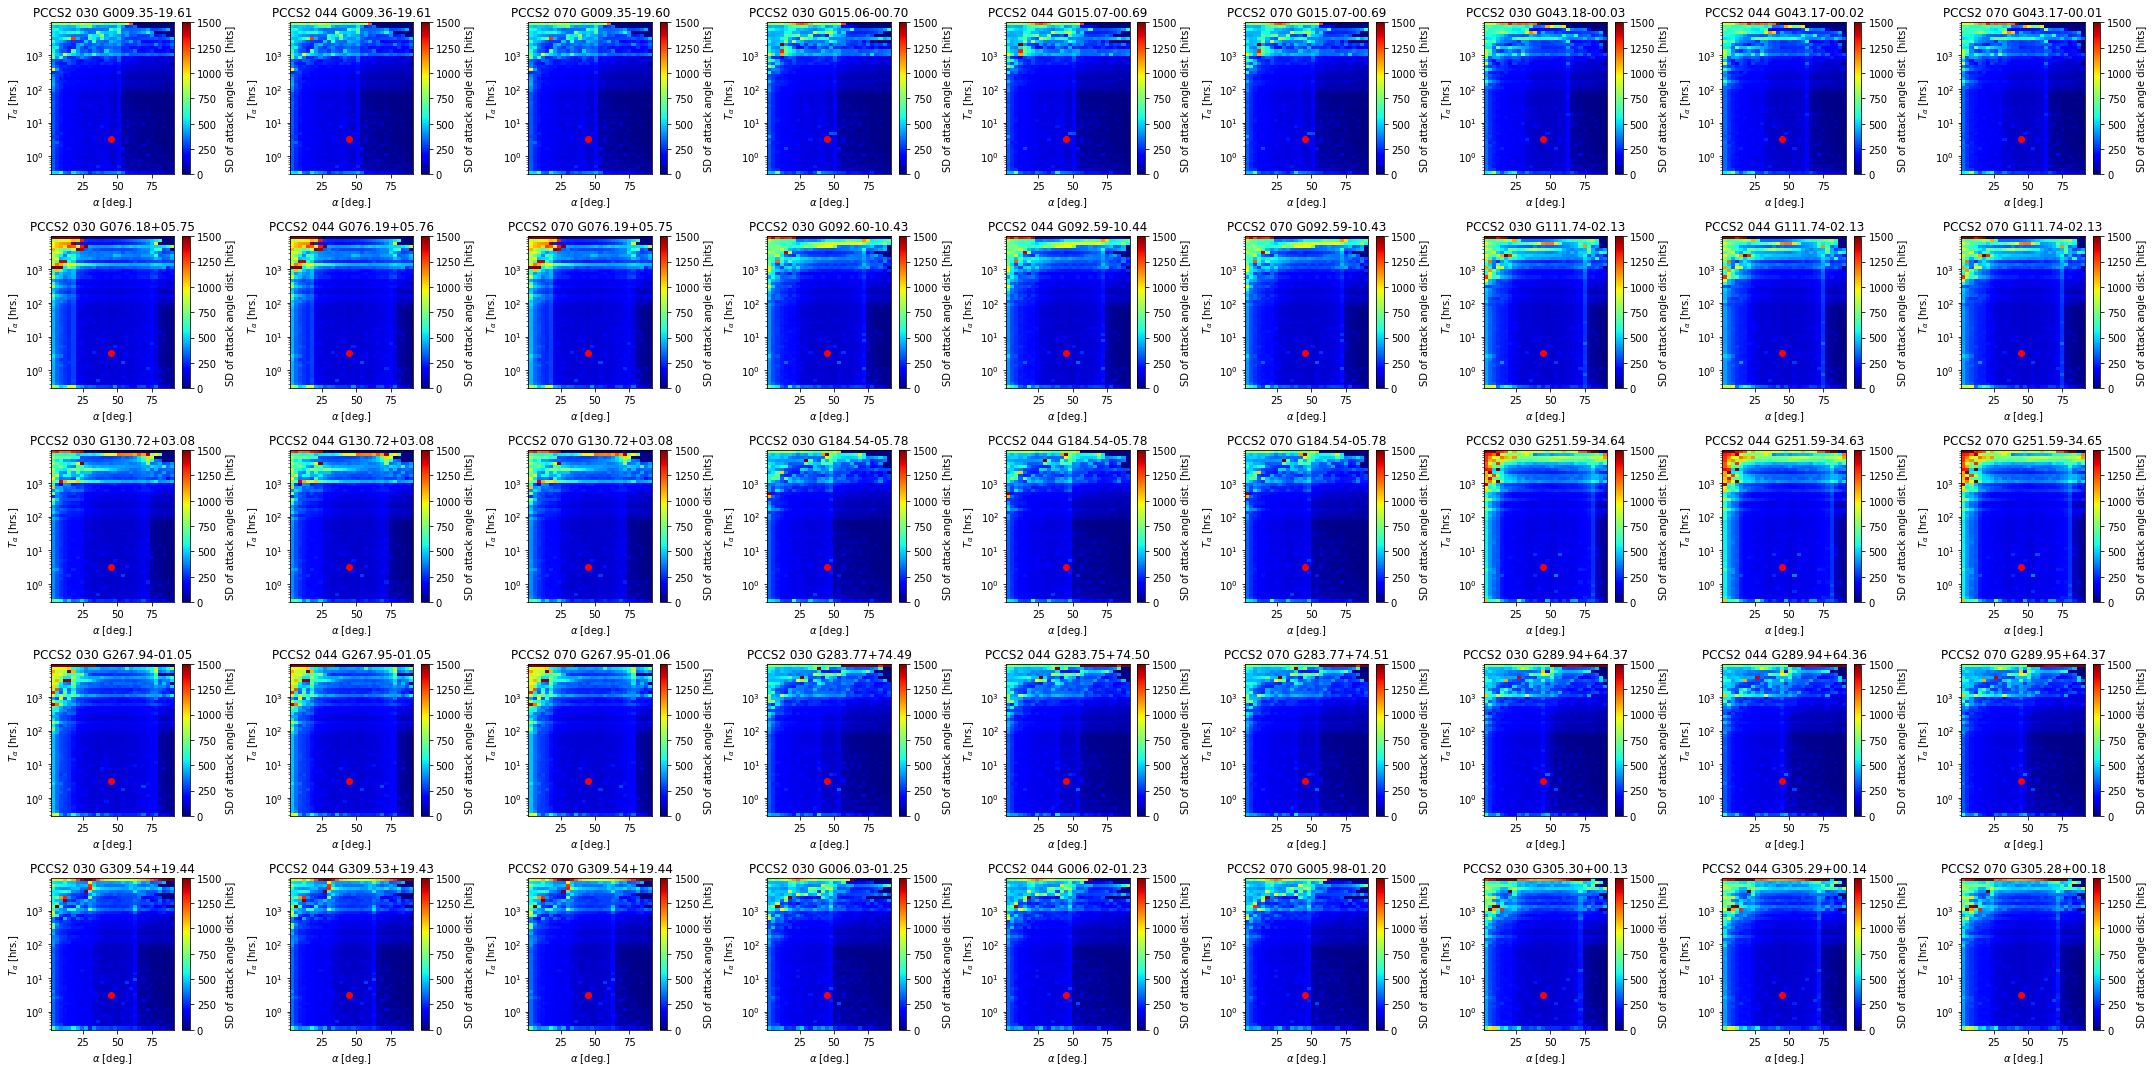

In [14]:
fig, axes = plt.subplots(5, 9, figsize=figsize)
k = 0
for i in range(5):
    for j in range(9):
        ax = axes[i, j]
        P = ax.pcolormesh(data["Alpha"], data["T_prec"]/60/60, data["pccs_psi_sd"][:,:,k], cmap="jet", vmin=0, vmax=1500)
        ax.scatter(45, 192.348/60, color="r")
        ax.set_xlabel(r"$\alpha$ [deg.]")
        ax.set_ylabel(r"$T_{\alpha}$ [hrs.]")
        ax.set_title("{}".format(df["NAME"][k]))
        ax.set_yscale("log")
        fig.colorbar(P, ax=ax, label=r"SD of attack angle dist. [hits]")
        k += 1
plt.tight_layout()

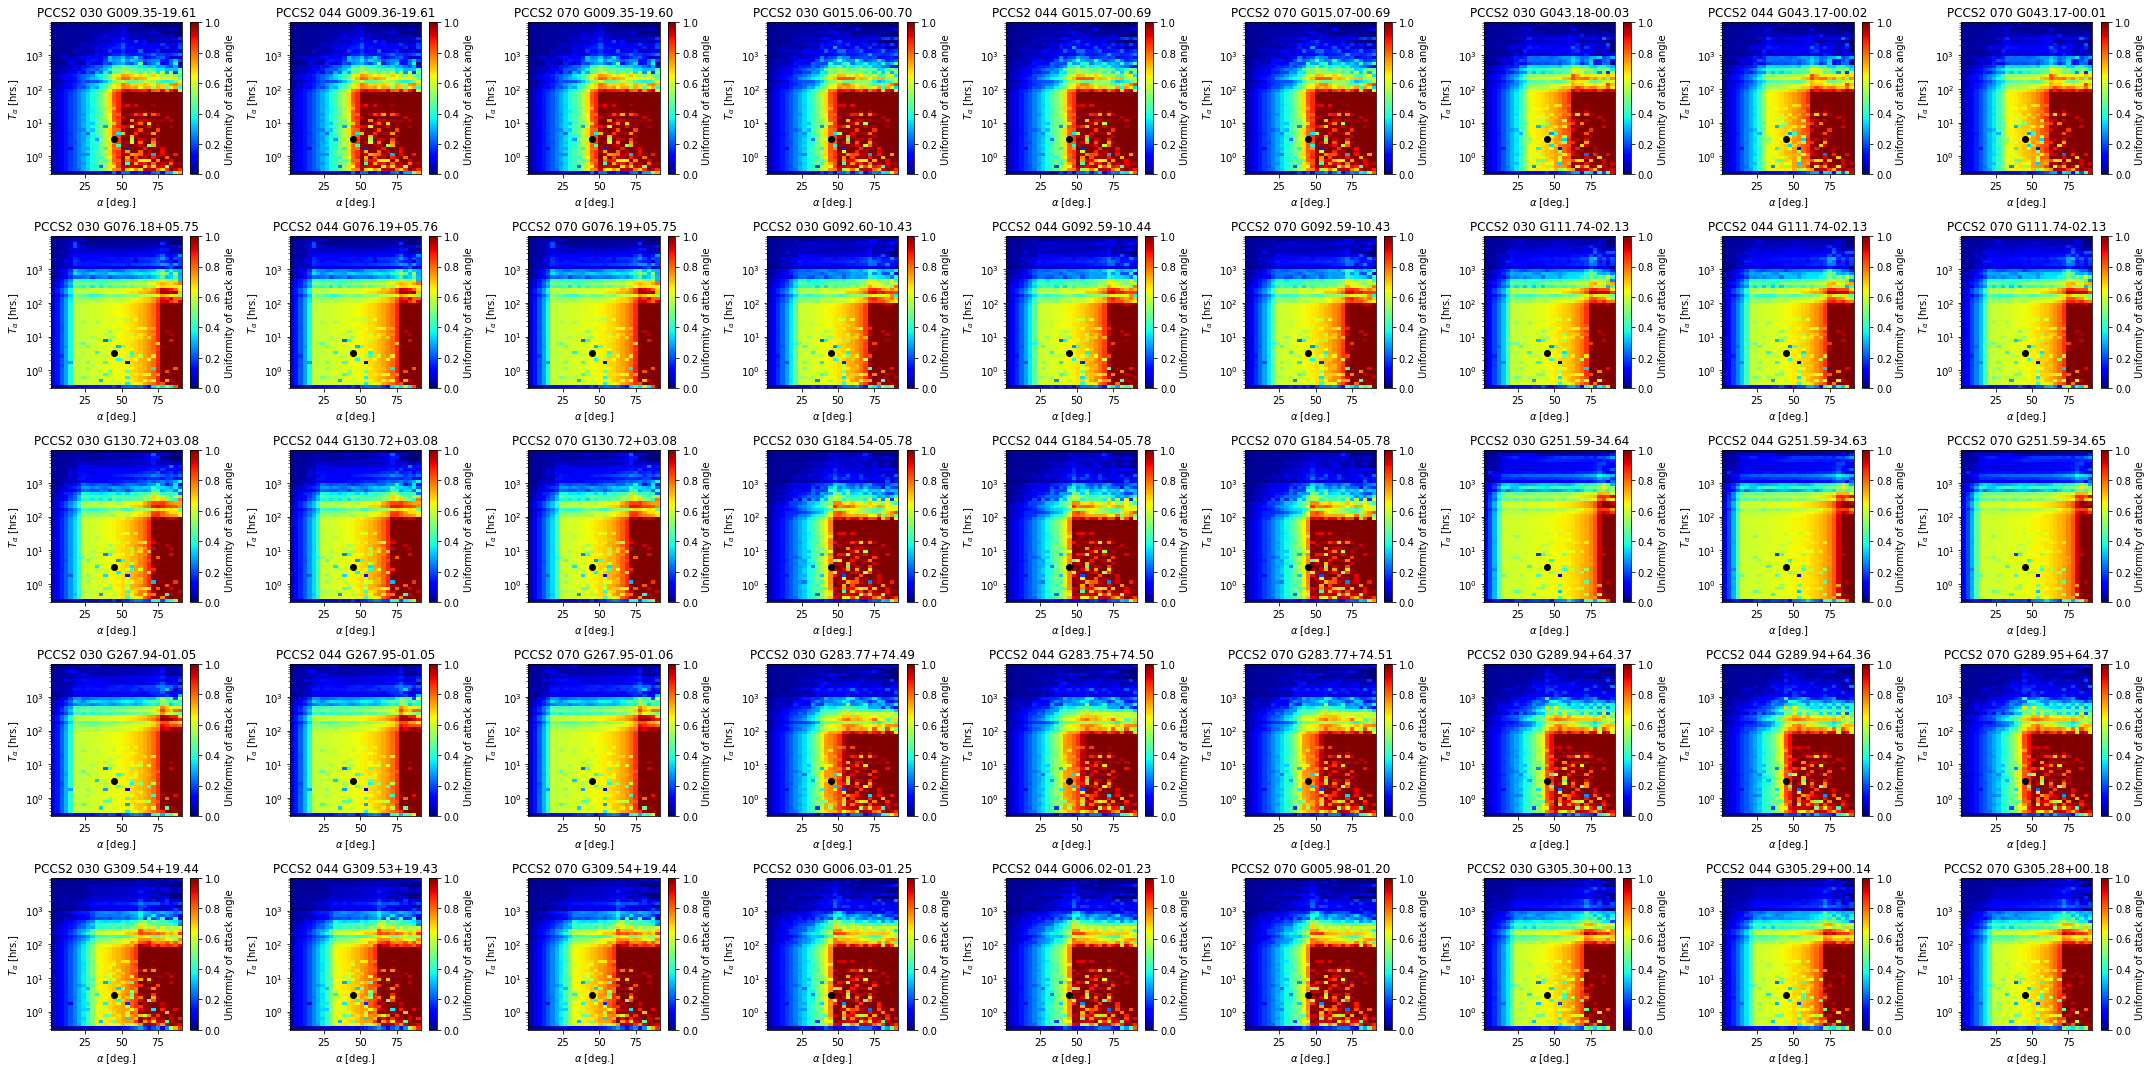

In [15]:
fig, axes = plt.subplots(5, 9, figsize=figsize)
k = 0
for i in range(5):
    for j in range(9):
        ax = axes[i, j]
        P = ax.pcolormesh(data["Alpha"], data["T_prec"]/60/60, data["pccs_psi_unifo"][:,:,k], cmap="jet", vmin=0, vmax=1)
        ax.scatter(45, 192.348/60, color="black")
        ax.set_xlabel(r"$\alpha$ [deg.]")
        ax.set_ylabel(r"$T_{\alpha}$ [hrs.]")
        ax.set_title("{}".format(df["NAME"][k]))
        ax.set_yscale("log")
        fig.colorbar(P, ax=ax, label=r"Uniformity of attack angle")
        k += 1
plt.tight_layout()